In [1]:
import cv2
import numpy as np
import math
import timeit
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
def extractForeground(img):
  '''extract foreground, the region in red'''
  #bgr format
  x_front, y_front = np.where(img[:,:,2] == 255)
  return x_front, y_front

In [3]:
def extractBackground(img):
  '''extract background, the region in blue'''
  #bgr format
  x_back, y_back = np.where(img[:,:,0] == 255)
  return x_back, y_back

In [4]:
def ClusterIndices(img, pixel_x, pixel_y, c_blue, c_green,  c_red, k = 64):
  '''return cluster indices for every point in extracted foregrounds'''
  clusters = np.zeros_like(pixel_x)
  for i in range(len(pixel_x)):
    dists = np.zeros(k, dtype=np.float32)
    b, g, r = img[pixel_x[i], pixel_y[i]]
    for j in range(k):
      dists[j] = math.sqrt(((int(r) - int(c_red[j]))**2) + ((int(g) - int(c_green[j]))**2) + ((int(b) - int(c_blue[j]))**2))
      if j == (k - 1):
        clusters[i] = (np.argmin(dists))

  return clusters



In [5]:
def KMeans(img, pixel_x, pixel_y, clusters=64):
  #equally spaced cluster locations
  placement = len(pixel_x)/clusters
  clusters_red = np.zeros(clusters, dtype=np.int16)
  clusters_green = np.zeros(clusters, dtype=np.int16)
  clusters_blue = np.zeros(clusters, dtype=np.int16)
  epsilon = 2 #cutoff differernce to act as breaking condition for kmeans

  random_indices = np.random.choice(len(pixel_x), clusters)
  pix = 0
  for val in random_indices:
    clusters_blue[pix], clusters_green[pix], clusters_red[pix] = img[pixel_x[val], pixel_y[val]]
    pix = pix + 1

  cluster_idxs = ClusterIndices(img, pixel_x, pixel_y, clusters_blue, clusters_green, clusters_red, k=clusters)

  m, itr = 0, 0
  while m == 0:
    print('Iteration: ', itr)
    itr += 1
    w = np.zeros(clusters, dtype=np.int16)
    updated_red = np.zeros(clusters, dtype=np.int16)
    updated_green = np.zeros(clusters, dtype=np.int16)
    updated_blue = np.zeros(clusters, dtype=np.int16)
    for i in range(clusters):
        #v = 0
        for j in range(len(pixel_x)):
            if cluster_idxs[j] == i:
                b, g, r = img[pixel_x[j], pixel_y[j]]
                # print(b, g, r)
                updated_red[i] += r
                updated_green[i] += g
                updated_blue[i] += b
                w[i] += 1
    for i in range(clusters):
        if w[i] != 0:
            updated_red[i] = updated_red[i] / w[i]
            updated_green[i] = updated_green[i] / w[i]
            updated_blue[i] = updated_blue[i] / w[i]
    for i in range(clusters):
        if abs(clusters_red[i] - updated_red[i]) > epsilon or abs(clusters_green[i] - updated_green[i]) > epsilon or abs(clusters_blue[i] - updated_blue[i]) > epsilon:
            cluster_idxs = ClusterIndices(img, pixel_x, pixel_y, updated_blue, updated_green, updated_red, k=clusters)
            clusters_red = updated_red
            clusters_green = updated_green
            clusters_blue = updated_blue
            break
        elif i == clusters-1:
            m = 1 #break while loop
  return cluster_idxs, updated_red, updated_green, updated_blue


In [6]:
def weights(clusters_neighbouring, clusters=64):
  '''calculates weighted average of all clusters'''
  wt = np.zeros(clusters, dtype=np.float32)
  for i in range(clusters):
      for j in range(len(clusters_neighbouring)):
          if clusters_neighbouring[j] == i:
              wt[i] += 1
          if j == len(clusters_neighbouring) - 1:
              wt[i] = wt[i] / len(clusters_neighbouring)
  return wt

In [7]:
def Pixel_Likelihood(original_img, weights_tuple, c_fore_tuple, c_back_tuple, clusters=64):
  weights_bg, weights_fore = weights_tuple
  red_fore, green_fore, blue_fore = c_fore_tuple
  red_back, green_back, blue_back = c_back_tuple
  img_result = original_img.copy()
  (h, w) = img_result.shape[:2]
  for i in tqdm(range(h)):
    for j in range(w):
        #print(i, j)
        prob_back = 0
        prob_front = 0
        for m in range(clusters):
            b, g, r = img_result[i, j]
            prob_back += weights_bg[m] * math.exp(-(math.sqrt(((r - red_back[m])**2) + ((g - green_back[m])**2)
                                                    + ((b - blue_back[m])**2))))
            prob_front += weights_fore[m] * math.exp(-(math.sqrt(((r - red_fore[m])**2) + ((g - green_fore[m])**2)
                                                    + ((b - blue_fore[m])**2))))
            if m == clusters - 1:

                if prob_front > prob_back:
                    img_result[i, j, :] = 255
                elif prob_front < prob_back:
                    img_result[i, j, :] = 0

  result = original_img.copy()
  print('Segmenting the original image')
  (h, w) = result.shape[:2]
  for i in tqdm(range(h)):
      for j in range(w):
          if img_result[i][j][0] == 0:
              result[i][j] = img_result[i][j]

  return result

In [117]:
seeds = cv2.imread('/content/lady_stroke_2.png')
img = cv2.imread('/content/lady.PNG')
fore_x, fore_y = extractForeground(seeds)
back_x, back_y = extractBackground(seeds)
fore_clusters, clustersFore_r, clustersFore_g, clustersFore_b = KMeans(img, fore_x, fore_y)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


In [118]:
back_clusters, clustersBack_r, clustersBack_g, clustersBack_b = KMeans(img, back_x, back_y)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4


In [119]:
weight_fore = weights(fore_clusters, clusters=64)
weight_back = weights(back_clusters, clusters=64)

In [120]:
wt_ = (weight_back, weight_fore)
clusters_fore_ = (clustersFore_r, clustersFore_g, clustersFore_b)
clusters_back_ = (clustersBack_r, clustersBack_g, clustersBack_b)
resultant_img = Pixel_Likelihood(img, wt_, clusters_fore_, clusters_back_)

100%|██████████| 480/480 [06:54<00:00,  1.16it/s]


Segmenting the original image


100%|██████████| 480/480 [00:00<00:00, 530.37it/s]


In [100]:
len(clustersBack_r) 

64

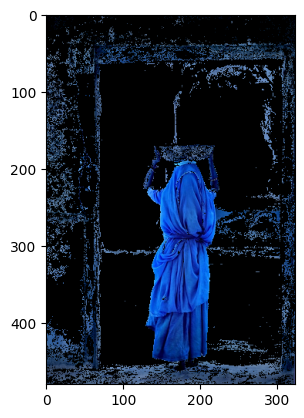

In [121]:
plt.imshow(resultant_img)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8


100%|██████████| 480/480 [07:29<00:00,  1.07it/s]


Segmenting the original image


100%|██████████| 480/480 [00:00<00:00, 1061.66it/s]


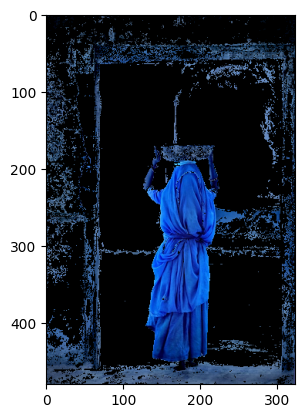

In [122]:
seeds = cv2.imread('/content/lady_stroke_1.png')
img = cv2.imread('/content/lady.PNG')
fore_x, fore_y = extractForeground(seeds)
back_x, back_y = extractBackground(seeds)
fore_clusters, clustersFore_r, clustersFore_g, clustersFore_b = KMeans(img, fore_x, fore_y)
back_clusters, clustersBack_r, clustersBack_g, clustersBack_b = KMeans(img, back_x, back_y)
weight_fore = weights(fore_clusters, clusters=64)
weight_back = weights(back_clusters, clusters=64)
wt_ = (weight_back, weight_fore)
clusters_fore_ = (clustersFore_r, clustersFore_g, clustersFore_b)
clusters_back_ = (clustersBack_r, clustersBack_g, clustersBack_b)
resultant_img = Pixel_Likelihood(img, wt_, clusters_fore_, clusters_back_)

plt.imshow(resultant_img)

In [ ]:
img = cv2.imread("/content/lady.PNG")
img_convert = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #defining image to experiment with number of clusters
img.shape

vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)

#image 2
K = 10
attempts=120
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image1 = res.reshape((img_convert.shape))

plt.imshow(result_image1)
plt.title('Segmented Image when K = 10'), plt.xticks([]), plt.yticks([])

In [94]:
np.unique(label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([14928, 21178, 27649,  9723, 15381,  7177, 11883, 18509,  8473,
        20139]))

#Using built-in functions

In [ ]:
seeds = cv2.imread('/content/lady_stroke_1.png')
img = cv2.imread('/content/lady.PNG')
fore_x, fore_y = extractForeground(seeds)
back_x, back_y = extractBackground(seeds)
fore_clusters, clustersFore_r, clustersFore_g, clustersFore_b = KMeans(img, fore_x, fore_y)
back_clusters, clustersBack_r, clustersBack_g, clustersBack_b = KMeans(img, back_x, back_y)
weight_fore = weights(fore_clusters, clusters=64)
weight_back = weights(back_clusters, clusters=64)
wt_ = (weight_back, weight_fore)
clusters_fore_ = (clustersFore_r, clustersFore_g, clustersFore_b)
clusters_back_ = (clustersBack_r, clustersBack_g, clustersBack_b)
resultant_img = Pixel_Likelihood(img, wt_, clusters_fore_, clusters_back_)

plt.imshow(resultant_img)

In [10]:
img2 = cv2.imread("/content/lady.PNG")
vectorized = img2.reshape((-1,3))
vectorized = np.float32(vectorized)
seed2 = cv2.imread("/content/lady_stroke_2.png")
vectorized2 = seed2.reshape((-1,3))
vectorized2 = np.float32(vectorized2)

fore_x, fore_y = extractForeground(seed2)
back_x, back_y = extractBackground(seed2)

K = 64
attempts=50
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 15, 1.0)
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
fore_clusters_bn = label.reshape(img2.shape[:2])[fore_x, fore_y]
fore_clusters_b_bn = center[:,0]
fore_clusters_g_bn = center[:,1]
fore_clusters_r_bn = center[:,2]


K = 64
attempts=50
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 15, 1.0)
ret,label,center=cv2.kmeans(vectorized2,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
back_clusters_bn = label.reshape(seed2.shape[:2])[fore_x, fore_y]
back_clusters_b_bn = center[:,0]
back_clusters_g_bn = center[:,1]
back_clusters_r_bn = center[:,2]

weight_fore = weights(fore_clusters_bn, clusters=64)
weight_back = weights(back_clusters_bn, clusters=64)
wt_ = (weight_back, weight_fore)
clusters_fore_ = (fore_clusters_r_bn, fore_clusters_g_bn, fore_clusters_r_bn)
clusters_back_ = (back_clusters_r_bn, back_clusters_g_bn, back_clusters_r_bn)
resultant_img = Pixel_Likelihood(img2, wt_, clusters_fore_, clusters_back_)


100%|██████████| 480/480 [06:12<00:00,  1.29it/s]


Segmenting the original image


100%|██████████| 480/480 [00:00<00:00, 1784.27it/s]


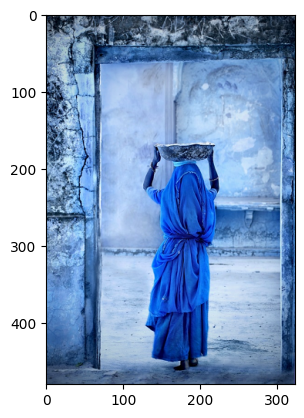

In [11]:
plt.imshow(resultant_img)

[Helping link 1](https://github.com/Azkarehman/Lazy-Snapping-Algorithm/blob/main/Lazy%20Snapping%20Report.pdf) \\
[Helping link 2](https://github.com/danialkhilji/Lazy-Snapping-Image-Segmentation/blob/master/image_segmentation_report.pdf) \\
[Helping link 3]() \\